### Working Dataset is Amazon Food Review Dataset. 
####     Features are username, product id, review text, score etc.


### Objective of this excercise
- Applying Naive Bayes on Text feature of the dataset and be able to differentiate the review text into positive or negative class
- Obtaining smoothing factor alpha by cross validation
- Getting the feature importance(here the significant words for each class)
- Getting different performance measure metric

#### Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sklearn

#### 1. Loading Data

In [2]:
con = sqlite3.connect('database.sqlite')

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score!=3""",con)

#### Entries having score 3 are discarded being considered as neutral reviews


In [3]:
actual_score = filtered_data['Score']

In [4]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [5]:
filtered_data['Score']=filtered_data['Score'].map(partition)

#### 2. Sorting data based on time

In [6]:
sorted_data = filtered_data.sort_values("Time",axis=0,ascending=True)

In [7]:
final = filtered_data.drop_duplicates(subset={'UserId','Time','ProfileName','Text'},keep='first',inplace=False)

#### Duplicate datas have been discarded


In [8]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#### 3. Data Cleaning and Preprocessing

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [10]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [11]:
stop.remove('not')

In [12]:
snb = nltk.stem.SnowballStemmer('english')

In [13]:
import re


In [14]:
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr,' ',sentence)
    return cleantxt
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\|\'|"|#]',r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned                 


In [15]:
i=0
str1=''
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split(" "):
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha())&(len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=cleaned_words.lower()
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i]=='positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i]=='negative':
                        all_negative_words.append(s)
                else:
                    continue
        else:
            continue
    str1 = " ".join(filtered_sentence)
    final_string.append(str1)
    i+=1

#### In above code snippet data cleansing has been done. Following things are included in that
- Stop Words removal, html tags removal, punctuation marks removal
- Converting everything to lowercase
- Lemmatization

In [16]:
final_df = pd.DataFrame(final_string)

final_df['Time']=final['Time']

final_df['Score']=final['Score']

In [17]:
final_df.dropna(axis=0,inplace=True)

In [18]:
final_df['Score']=final_df['Score'].map({'positive':1,'negative':-1})

In [19]:
final_df.shape

(265265, 3)

In [20]:
final_df.head(5)

,0,Time,Score
0,bought several vitality canned dog food produc...,1.303862e+09,1
1,product arrived labeled jumbo salted peanuts p...,1.346976e+09,-1
2,confection around centuries light pillowy citr...,1.219018e+09,1
3,looking secret ingredient robitussin believe f...,1.307923e+09,-1
4,great taffy great price wide assortment yummy ...,1.350778e+09,1


In [21]:
X=final_df[0].values

In [22]:
y=final_df["Score"].values

#### 4. Splitting dataset into train test set based on time 

In [23]:
X_1=X[0:212212]
y_1=y[0:212212]
X_test=X[212212:265265]
y_test=y[212212:265265]

#### 5.1 Building Count Vectorizer with training data

In [24]:
count_vect = CountVectorizer()
final_counts_X1 = count_vect.fit_transform(X_1)

Obtained the Bag of Words 

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB


#### 5.2 Applying BernouliNB on that training data for cross validation

In [34]:
accuracy=[]
dict1 = {}
for a in np.arange(pow(10,-5),pow(10,-2),0.00001):
    X_train=final_counts_X1[0:169769,:]
    y_train=y_1[0:169769]
    X_cv=final_counts_X1[169769:212212,:]
    y_cv=y_1[169769:212212]
    neigh = BernoulliNB(alpha=a)
    neigh.fit(X_train,y_train)
    pred = neigh.predict(X_cv)
    score = accuracy_score(y_cv,pred,normalize=True)*float(100)
    #print('Accuracy Score for alpha={} is {}'.format(a,score))
    accuracy.append(score)
    dict1[score]=a
print('alpha value for maximum accuracy is {} with accuracy {}'.format(dict1[max(accuracy)],max(accuracy)))

alpha value for maximum accuracy is 1e-05 with accuracy 79.10609523360743


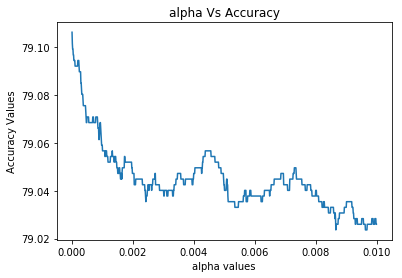

In [35]:
plt.plot(np.arange(pow(10,-5),pow(10,-2),0.00001),accuracy)
plt.title('alpha Vs Accuracy')
plt.xlabel('alpha values')
plt.ylabel('Accuracy Values')
plt.show()

 The optimal alpha obtained by single fold cross validation is 1e-05

In [52]:
accuracy=[]
dict1 = {}
for a in np.arange(pow(10,-5),pow(10,-3),0.00001):
    score_total=0.0
    for i in range(0,10):
        
        X_train=final_counts[0:21221*(i+1),:]
        y_train=y_1[0:21221*(i+1)]
        X_cv=final_counts[21221*(i+1):21221*(i+2),:]
        y_cv=y_1[21221*(i+1):21221*(i+2)]
        #Here we splitted the data in Train and Cross Validation set
        neigh = BernoulliNB(alpha=a)
        neigh.fit(X_train,y_train)
        pred = neigh.predict(X_cv)
        score = sklearn.metrics.accuracy_score(y_cv,pred,normalize=True)*float(100)
        score_total=score+score_total
    accuracy.append(score_total/float(10))
    score_avg=score_total/float(10)
    dict1[score_avg]=a
print('alpha value for maximum accuracy is {} with accuracy {}'.format(dict1[max(accuracy)],max(accuracy)))

alpha value for maximum accuracy is 1e-05 with accuracy 74.99811507469016


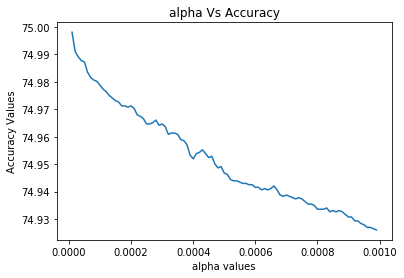

In [53]:
plt.plot(np.arange(pow(10,-5),pow(10,-3),0.00001),accuracy)
plt.title('alpha Vs Accuracy')
plt.xlabel('alpha values')
plt.ylabel('Accuracy Values')
plt.show()

 Optimum alpha with 10 fold cross validation is also 1e-05 

#### 5.3 Deriving Vectors for Test data

In [25]:
final_counts_Xtest = count_vect.transform(X_test)

#### 5.4 Applying BernoulliNB with optimal 'alpha' value obtained from cross validation on train data to get the model

In [36]:
neigh_optimal = BernoulliNB(alpha= 1e-05)
neigh_optimal.fit(final_counts_X1,y_1)


BernoulliNB(alpha=1e-05, binarize=0.0, class_prior=None, fit_prior=True)

#### 5.5 Getting importnt features for both positive and negative class

In [37]:

neg_class_prob_sorted = np.flip(neigh_optimal.feature_log_prob_[0,:].argsort(),axis=0)
pos_class_prob_sorted = np.flip(neigh_optimal.feature_log_prob_[1, :].argsort(),axis=0)
print('Imfortant features for negative class: ',np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:100]))

Imfortant features for negative class:  ['not' 'like' 'good' 'great' 'one' 'taste' 'product' 'love' 'flavor'
 'would' 'get' 'really' 'much' 'amazon' 'time' 'also' 'use' 'best' 'buy'
 'little' 'find' 'tried' 'even' 'make' 'price' 'coffee' 'well' 'try'
 'better' 'food' 'eat' 'first' 'used' 'found' 'tea' 'bought' 'made' 'way'
 'recommend' 'tastes' 'delicious' 'sweet' 'store' 'think' 'could' 'since'
 'two' 'sugar' 'day' 'order' 'bag' 'still' 'water' 'give' 'many'
 'favorite' 'never' 'nice' 'bit' 'know' 'drink' 'got' 'years' 'makes'
 'box' 'every' 'want' 'chocolate' 'without' 'add' 'right' 'always' 'ever'
 'lot' 'easy' 'perfect' 'stuff' 'something' 'mix' 'brand' 'different'
 'loves' 'cup' 'say' 'enough' 'less' 'free' 'ordered' 'keep' 'need' 'put'
 'back' 'dog' 'fresh' 'hot' 'flavors' 'quality' 'healthy' 'using' 'sure']


In [38]:
print('Important features for positive class: ',np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:100]))

Important features for positive class:  ['not' 'like' 'good' 'great' 'one' 'taste' 'product' 'love' 'flavor'
 'would' 'get' 'really' 'much' 'amazon' 'also' 'time' 'use' 'best' 'buy'
 'little' 'find' 'tried' 'price' 'make' 'even' 'coffee' 'well' 'better'
 'try' 'food' 'first' 'eat' 'found' 'used' 'tea' 'bought' 'made' 'way'
 'recommend' 'delicious' 'store' 'tastes' 'since' 'sweet' 'think' 'two'
 'could' 'sugar' 'order' 'bag' 'still' 'day' 'water' 'nice' 'know' 'many'
 'favorite' 'never' 'got' 'give' 'bit' 'box' 'drink' 'makes' 'want'
 'without' 'years' 'every' 'chocolate' 'always' 'right' 'something' 'ever'
 'add' 'stuff' 'cup' 'free' 'lot' 'mix' 'perfect' 'say' 'easy' 'loves'
 'back' 'brand' 'enough' 'fresh' 'ordered' 'keep' 'less' 'quality' 'dog'
 'different' 'using' 'put' 'small' 'flavors' 'need' 'healthy' 'sure']


 Above we got most common words corresponding to each class
 But one thing to notice, a lot of words are common between these two classes. This means the text dataset has overlapping data

#### 5.6 Applying obtained model on test dataset to get accuracy metrices

In [39]:
pred = neigh_optimal.predict(final_counts_Xtest)

In [40]:
accuracy_score = sklearn.metrics.accuracy_score(y_test,pred)
print('The accuracy score of Naive Bayes on 20% test data is ',accuracy_score*float(100))

The accuracy score of Naive Bayes on 20% test data is  81.90488756526493


#### Accuracy score is 81.904%

In [41]:
con_matrix = sklearn.metrics.confusion_matrix(y_test,pred,labels=[-1,1])
con_matrix

array([[  289,  8030],
       [ 1570, 43164]], dtype=int64)

In [42]:
from seaborn import heatmap

[]

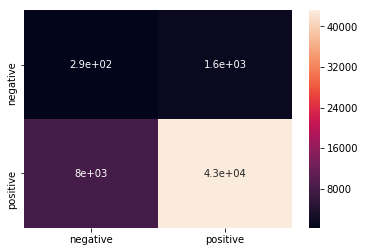

In [43]:
df_cm = pd.DataFrame(con_matrix.T, index = ['negative','positive'],
                  columns = ['negative','positive'])
heatmap(df_cm,annot=True)
plt.plot()

#### Above is the confusion matrix

In [44]:
tn,fp,fn,tp = sklearn.metrics.confusion_matrix(y_test,pred,labels=[-1,1]).ravel()

In [45]:
prec_score = sklearn.metrics.precision_score(y_test,pred,labels=[-1,1],pos_label=1)
print('The precision score of Naive Bayes on 20% test data is ',prec_score*float(100))

The precision score of Naive Bayes on 20% test data is  84.31456811345079


#### Precision Score is 84.31%

In [46]:
print('TPR is ',float(tp/(tp+fn)))
print('FPR is ',float(fp/(tn+fp)))
print('TNR is ',float(tn/(tn+fp)))
print('FNR is ',float(fn/(tp+fn)))

TPR is  0.9649036527026423
FPR is  0.9652602476259166
TNR is  0.03473975237408342
FNR is  0.035096347297357715


In [48]:
recall_score = sklearn.metrics.recall_score(y_test,pred,pos_label=1)
recall_score

0.9649036527026423

#### Recall Score 96.49% which is nothhing but TPR

In [49]:
f1_score = sklearn.metrics.f1_score(y_test,pred,pos_label=1)
f1_score

0.8999249437077808

#### F1 Score is 89.9%

In [50]:
from sklearn import metrics

In [51]:
print('Classification report for Naive Bayes on the selected ssample is\n\n',metrics.classification_report(y_test,pred))

Classification report for Naive Bayes on the selected ssample is

              precision    recall  f1-score   support

         -1       0.16      0.03      0.06      8319
          1       0.84      0.96      0.90     44734

avg / total       0.74      0.82      0.77     53053



#### 5.7 Applying MultinomialNB on train data

In [26]:
from sklearn.naive_bayes import MultinomialNB

In [28]:
accuracy=[]
dict1 = {}
for a in np.arange(pow(10,-5),pow(10,-2),0.00001):
    X_train=final_counts_X1[0:169769,:]
    y_train=y_1[0:169769]
    X_cv=final_counts_X1[169769:212212,:]
    y_cv=y_1[169769:212212]
    neigh = MultinomialNB(alpha=a)
    neigh.fit(X_train,y_train)
    pred = neigh.predict(X_cv)
    score = accuracy_score(y_cv,pred,normalize=True)*float(100)
    #print('Accuracy Score for alpha={} is {}'.format(a,score))
    accuracy.append(score)
    dict1[score]=a
print('alpha value for maximum accuracy is {} with accuracy {}'.format(dict1[max(accuracy)],max(accuracy)))

alpha value for maximum accuracy is 1e-05 with accuracy 78.37805998633462


In [30]:
nb=MultinomialNB(alpha= 1e-05)
nb.fit(final_counts_X1,y_1)

MultinomialNB(alpha=1e-05, class_prior=None, fit_prior=True)

#### 5.8 Getting feature importance for both positive and negative class

In [32]:

neg_class_prob = np.flip(nb.feature_log_prob_[0,:].argsort(),axis=0)
pos_class_prob = np.flip(nb.feature_log_prob_[1, :].argsort(),axis=0)
print('Imfortant features for negative class: ',np.take(count_vect.get_feature_names(), neg_class_prob[:100]))

Imfortant features for negative class:  ['not' 'like' 'good' 'great' 'one' 'taste' 'product' 'coffee' 'flavor'
 'tea' 'love' 'would' 'food' 'get' 'really' 'amazon' 'much' 'use' 'time'
 'also' 'little' 'best' 'buy' 'even' 'tried' 'make' 'price' 'find' 'well'
 'better' 'try' 'eat' 'chocolate' 'first' 'water' 'sugar' 'used' 'dog'
 'found' 'bag' 'made' 'sweet' 'bought' 'drink' 'way' 'box' 'store' 'two'
 'think' 'tastes' 'day' 'since' 'could' 'delicious' 'order' 'recommend'
 'mix' 'still' 'cup' 'many' 'bit' 'give' 'nice' 'know' 'add' 'never'
 'years' 'hot' 'got' 'favorite' 'want' 'free' 'every' 'brand' 'stuff'
 'makes' 'milk' 'always' 'without' 'right' 'easy' 'lot' 'something' 'ever'
 'perfect' 'different' 'enough' 'say' 'less' 'flavors' 'loves' 'oil'
 'ordered' 'organic' 'sauce' 'healthy' 'quality' 'put' 'fresh' 'keep']


In [33]:
print('Important features for positive class: ',np.take(count_vect.get_feature_names(), pos_class_prob[:100]))

Important features for positive class:  ['not' 'like' 'good' 'great' 'one' 'taste' 'product' 'coffee' 'flavor'
 'tea' 'love' 'would' 'food' 'get' 'really' 'amazon' 'use' 'much' 'also'
 'time' 'little' 'best' 'make' 'buy' 'price' 'find' 'tried' 'even' 'well'
 'better' 'try' 'chocolate' 'eat' 'water' 'first' 'sugar' 'used' 'dog'
 'found' 'bag' 'made' 'drink' 'bought' 'sweet' 'box' 'way' 'two' 'store'
 'think' 'tastes' 'since' 'delicious' 'cup' 'day' 'could' 'order'
 'recommend' 'mix' 'still' 'nice' 'many' 'know' 'bit' 'got' 'add' 'free'
 'give' 'never' 'favorite' 'hot' 'want' 'milk' 'stuff' 'years' 'makes'
 'every' 'without' 'something' 'always' 'brand' 'right' 'lot' 'organic'
 'ever' 'flavors' 'fresh' 'easy' 'perfect' 'quality' 'say' 'back' 'less'
 'healthy' 'using' 'enough' 'loves' 'small' 'ordered' 'keep' 'put']


Above we got most common words corresponding to each class
But one thing to notice, a lot of words are common between these two classes. This means the text dataset has overlapping data

#### 5.8 Applying model on test data to get permormance metrices

In [34]:
pred = nb.predict(final_counts_Xtest)

In [35]:
accuracy_score = sklearn.metrics.accuracy_score(y_test,pred)
print('The accuracy score of Naive Bayes on 20% test data is ',accuracy_score*float(100))

The accuracy score of Naive Bayes on 20% test data is  81.02086592652631


#### Accuracy score is 81.020%

In [36]:
con_matrix = sklearn.metrics.confusion_matrix(y_test,pred,labels=[-1,1])
con_matrix

array([[  391,  7928],
       [ 2141, 42593]], dtype=int64)

In [37]:
from seaborn import heatmap

[]

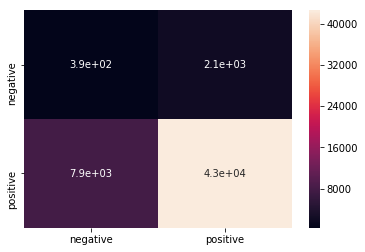

In [38]:
df_cm = pd.DataFrame(con_matrix.T, index = ['negative','positive'],
                  columns = ['negative','positive'])
heatmap(df_cm,annot=True)
plt.plot()

#### Above is the confusion matrix

In [63]:
tn,fp,fn,tp = sklearn.metrics.confusion_matrix(y_test,pred,labels=[-1,1]).ravel()

In [64]:
prec_score = sklearn.metrics.precision_score(y_test,pred,labels=[-1,1],pos_label=1)
print('The precision score of Naive Bayes on 20% test data is ',prec_score*float(100))

The precision score of Naive Bayes on 20% test data is  84.30751568654618


#### Precision Score is 84.30%

In [65]:
print('TPR is ',float(tp/(tp+fn)))
print('FPR is ',float(fp/(tn+fp)))
print('TNR is ',float(tn/(tn+fp)))
print('FNR is ',float(fn/(tp+fn)))

TPR is  0.9521393123798453
FPR is  0.9529991585527107
TNR is  0.04700084144728934
FNR is  0.04786068762015469


In [66]:
recall_score = sklearn.metrics.recall_score(y_test,pred,pos_label=1)
recall_score

0.9521393123798453

#### Recall Score 95.21% which is nothhing but TPR

In [67]:
f1_score = sklearn.metrics.f1_score(y_test,pred,pos_label=1)
f1_score

0.8942942627683587

#### F1 Score is 89.4%

In [68]:
from sklearn import metrics

In [69]:
print('Classification report for Naive Bayes on the selected ssample is\n\n',metrics.classification_report(y_test,pred))

Classification report for Naive Bayes on the selected ssample is

              precision    recall  f1-score   support

         -1       0.15      0.05      0.07      8319
          1       0.84      0.95      0.89     44734

avg / total       0.74      0.81      0.77     53053



#### 6.1 Building tfidf vectorizer with train data

In [39]:
tfidf_vect=TfidfVectorizer()
final_tfidf_X1=tfidf_vect.fit_transform(X_1)

Tfidf Vectors created

#### 6.2 Applying BernouliNB on train data

In [43]:
accuracy=[]
dict1 = {}
for a in np.arange(pow(10,-5),pow(10,-2),0.00001):
    X_train=final_tfidf[0:169769,:]
    y_train=y_1[0:169769]
    X_cv=final_tfidf[169769:212212,:]
    y_cv=y_1[169769:212212]
    neigh = BernoulliNB(alpha=a)
    neigh.fit(X_train,y_train)
    pred = neigh.predict(X_cv)
    score = metrics.accuracy_score(y_cv,pred,normalize=True)*float(100)
    #print('Accuracy Score for alpha={} is {}'.format(a,score))
    accuracy.append(score)
    dict1[score]=a
print('alpha value for maximum accuracy is {} with accuracy {}'.format(dict1[max(accuracy)],max(accuracy)))

alpha value for maximum accuracy is 1e-05 with accuracy 79.10609523360743


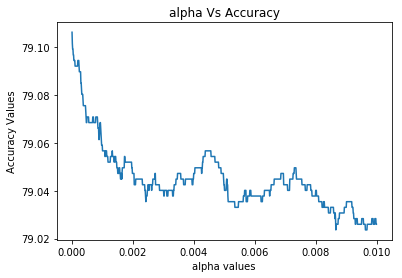

In [26]:
plt.plot(np.arange(pow(10,-5),pow(10,-2),0.00001),accuracy)
plt.title('alpha Vs Accuracy')
plt.xlabel('alpha values')
plt.ylabel('Accuracy Values')
plt.show()

#### The optimal alpha obtained by single fold cross validation is 1e-05

In [52]:
accuracy=[]
dict1 = {}
for a in np.arange(pow(10,-5),pow(10,-3),0.00001):
    score_total=0.0
    for i in range(0,10):
        
        X_train=final_counts[0:21221*(i+1),:]
        y_train=y_1[0:21221*(i+1)]
        X_cv=final_counts[21221*(i+1):21221*(i+2),:]
        y_cv=y_1[21221*(i+1):21221*(i+2)]
        #Here we splitted the data in Train and Cross Validation set
        neigh = BernoulliNB(alpha=a)
        neigh.fit(X_train,y_train)
        pred = neigh.predict(X_cv)
        score = sklearn.metrics.accuracy_score(y_cv,pred,normalize=True)*float(100)
        score_total=score+score_total
    accuracy.append(score_total/float(10))
    score_avg=score_total/float(10)
    dict1[score_avg]=a
print('alpha value for maximum accuracy is {} with accuracy {}'.format(dict1[max(accuracy)],max(accuracy)))

alpha value for maximum accuracy is 1e-05 with accuracy 74.99811507469016


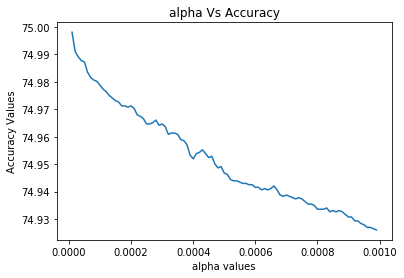

In [53]:
plt.plot(np.arange(pow(10,-5),pow(10,-3),0.00001),accuracy)
plt.title('alpha Vs Accuracy')
plt.xlabel('alpha values')
plt.ylabel('Accuracy Values')
plt.show()

#### Optimum alpha with 10 fold cross validation is also 1e-05 

#### 6.3 Fitting model with optimal hyperparameter 

In [27]:
neigh_optimal = BernoulliNB(alpha= 1e-05)
neigh_optimal.fit(final_tfidf,y_1)


BernoulliNB(alpha=1e-05, binarize=0.0, class_prior=None, fit_prior=True)

#### 6.4 Getting important features

In [29]:

neg_class_prob_sorted = np.flip(neigh_optimal.feature_log_prob_[0,:].argsort(),axis=0)
pos_class_prob_sorted = np.flip(neigh_optimal.feature_log_prob_[1, :].argsort(),axis=0)
print('Imfortant features for negative class: ',np.take(tfidf_vect.get_feature_names(), neg_class_prob_sorted[:100]))

Imfortant features for negative class:  ['not' 'like' 'good' 'great' 'one' 'taste' 'product' 'love' 'flavor'
 'would' 'get' 'really' 'much' 'amazon' 'time' 'also' 'use' 'best' 'buy'
 'little' 'find' 'tried' 'even' 'make' 'price' 'coffee' 'well' 'try'
 'better' 'food' 'eat' 'first' 'used' 'found' 'tea' 'bought' 'made' 'way'
 'recommend' 'tastes' 'delicious' 'sweet' 'store' 'think' 'could' 'since'
 'two' 'sugar' 'day' 'order' 'bag' 'still' 'water' 'give' 'many'
 'favorite' 'never' 'nice' 'bit' 'know' 'drink' 'got' 'years' 'makes'
 'box' 'every' 'want' 'chocolate' 'without' 'add' 'right' 'always' 'ever'
 'lot' 'easy' 'perfect' 'stuff' 'something' 'mix' 'brand' 'different'
 'loves' 'cup' 'say' 'enough' 'less' 'free' 'ordered' 'keep' 'need' 'put'
 'back' 'dog' 'fresh' 'hot' 'flavors' 'quality' 'healthy' 'using' 'sure']


In [30]:
print('Important features for positive class: ',np.take(tfidf_vect.get_feature_names(), pos_class_prob_sorted[:100]))

Important features for positive class:  ['not' 'like' 'good' 'great' 'one' 'taste' 'product' 'love' 'flavor'
 'would' 'get' 'really' 'much' 'amazon' 'also' 'time' 'use' 'best' 'buy'
 'little' 'find' 'tried' 'price' 'make' 'even' 'coffee' 'well' 'better'
 'try' 'food' 'first' 'eat' 'found' 'used' 'tea' 'bought' 'made' 'way'
 'recommend' 'delicious' 'store' 'tastes' 'since' 'sweet' 'think' 'two'
 'could' 'sugar' 'order' 'bag' 'still' 'day' 'water' 'nice' 'know' 'many'
 'favorite' 'never' 'got' 'give' 'bit' 'box' 'drink' 'makes' 'want'
 'without' 'years' 'every' 'chocolate' 'always' 'right' 'something' 'ever'
 'add' 'stuff' 'cup' 'free' 'lot' 'mix' 'perfect' 'say' 'easy' 'loves'
 'back' 'brand' 'enough' 'fresh' 'ordered' 'keep' 'less' 'quality' 'dog'
 'different' 'using' 'put' 'small' 'flavors' 'need' 'healthy' 'sure']


Above we got most common words corresponding to each class
But one thing to notice, a lot of words are common between these two classes. This means the text dataset has overlapping data

#### 6.5 Obtaining test vectors and applying the model to it to get performance metrices

In [31]:
X_test_vector=tfidf_vect.transform(X_test)

In [32]:
pred = neigh_optimal.predict(X_test_vector)

In [33]:
accuracy_score = sklearn.metrics.accuracy_score(y_test,pred)
print('The accuracy score of Naive Bayes on 20% test data is ',accuracy_score*float(100))

The accuracy score of Naive Bayes on 20% test data is  81.90488756526493


#### Accuracy score is 81.904%

In [34]:
con_matrix = sklearn.metrics.confusion_matrix(y_test,pred,labels=['negative','positive'])
con_matrix

array([[  289,  8030],
       [ 1570, 43164]], dtype=int64)

In [35]:
from seaborn import heatmap

[]

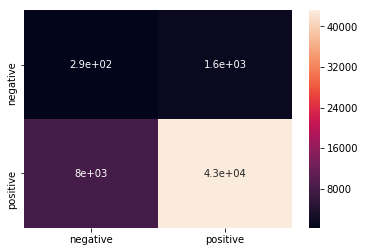

In [36]:
df_cm = pd.DataFrame(con_matrix.T, index = ['negative','positive'],
                  columns = ['negative','positive'])
heatmap(df_cm,annot=True)
plt.plot()

#### Above is the confusion matrix

In [37]:
tn,fp,fn,tp = sklearn.metrics.confusion_matrix(y_test,pred,labels=['negative','positive']).ravel()

In [38]:
prec_score = sklearn.metrics.precision_score(y_test,pred,labels=['negative','positive'],pos_label='positive')
print('The precision score of Naive Bayes on 20% test data is ',prec_score*float(100))

The precision score of Naive Bayes on 20% test data is  84.31456811345079


#### Precision Score is 84.31%

In [39]:
print('TPR is ',float(tp/(tp+fn)))
print('FPR is ',float(fp/(tn+fp)))
print('TNR is ',float(tn/(tn+fp)))
print('FNR is ',float(fn/(tp+fn)))

TPR is  0.9649036527026423
FPR is  0.9652602476259166
TNR is  0.03473975237408342
FNR is  0.035096347297357715


In [40]:
recall_score = sklearn.metrics.recall_score(y_test,pred,pos_label='positive')
recall_score

0.9649036527026423

#### Recall Score 96.49% which is nothhing but TPR

In [41]:
f1_score = sklearn.metrics.f1_score(y_test,pred,pos_label='positive')
f1_score

0.8999249437077808

#### F1 Score is 89.9%

In [42]:
from sklearn import metrics

In [43]:
print('Classification report for Naive Bayes on the selected ssample is\n\n',metrics.classification_report(y_test,pred))

Classification report for Naive Bayes on the selected ssample is

              precision    recall  f1-score   support

   negative       0.16      0.03      0.06      8319
   positive       0.84      0.96      0.90     44734

avg / total       0.74      0.82      0.77     53053



#### 6.6 Applying MultinomialNB on train data

In [45]:
accuracy=[]
dict1 = {}
for a in np.arange(pow(10,-5),pow(10,-2),0.00001):
    X_train=final_tfidf[0:169769,:]
    y_train=y_1[0:169769]
    X_cv=final_tfidf[169769:212212,:]
    y_cv=y_1[169769:212212]
    neigh = MultinomialNB(alpha=a)
    neigh.fit(X_train,y_train)
    pred = neigh.predict(X_cv)
    score = metrics.accuracy_score(y_cv,pred,normalize=True)*float(100)
    #print('Accuracy Score for alpha={} is {}'.format(a,score))
    accuracy.append(score)
    dict1[score]=a
print('alpha value for maximum accuracy is {} with accuracy {}'.format(dict1[max(accuracy)],max(accuracy)))

alpha value for maximum accuracy is 0.00999 with accuracy 83.6580826049054


In [ ]:
#### Optimal alpha value is 0.00999 with accuracy score 83.65%

In [46]:
nb=MultinomialNB(alpha=0.00999)

In [47]:
nb.fit(final_tfidf,y_1)

MultinomialNB(alpha=0.00999, class_prior=None, fit_prior=True)

#### 6.7 Getting important features

In [49]:

neg_class_prob_sorted = np.flip(nb.feature_log_prob_[0,:].argsort(),axis=0)
pos_class_prob_sorted = np.flip(nb.feature_log_prob_[1, :].argsort(),axis=0)
print('Imfortant features for negative class: ',np.take(tfidf_vect.get_feature_names(), neg_class_prob_sorted[:100]))

Imfortant features for negative class:  ['not' 'great' 'like' 'good' 'coffee' 'taste' 'product' 'tea' 'love' 'one'
 'flavor' 'would' 'really' 'food' 'amazon' 'get' 'price' 'best' 'buy'
 'much' 'use' 'time' 'find' 'little' 'tried' 'chocolate' 'better' 'also'
 'make' 'well' 'even' 'eat' 'try' 'dog' 'bought' 'sugar' 'delicious'
 'sweet' 'order' 'used' 'tastes' 'found' 'store' 'drink' 'water' 'bag'
 'recommend' 'first' 'box' 'favorite' 'loves' 'made' 'nice' 'way' 'day'
 'mix' 'easy' 'cup' 'perfect' 'hot' 'could' 'ever' 'free' 'think' 'stuff'
 'since' 'add' 'got' 'never' 'many' 'makes' 'two' 'ordered' 'years'
 'every' 'always' 'bit' 'brand' 'give' 'still' 'right' 'snack' 'fresh'
 'flavors' 'dogs' 'healthy' 'know' 'milk' 'tasty' 'treats' 'without' 'lot'
 'want' 'excellent' 'hard' 'wonderful' 'sauce' 'different' 'quality'
 'keep']


In [30]:
print('Important features for positive class: ',np.take(tfidf_vect.get_feature_names(), pos_class_prob_sorted[:100]))

Important features for positive class:  ['not' 'like' 'good' 'great' 'one' 'taste' 'product' 'love' 'flavor'
 'would' 'get' 'really' 'much' 'amazon' 'also' 'time' 'use' 'best' 'buy'
 'little' 'find' 'tried' 'price' 'make' 'even' 'coffee' 'well' 'better'
 'try' 'food' 'first' 'eat' 'found' 'used' 'tea' 'bought' 'made' 'way'
 'recommend' 'delicious' 'store' 'tastes' 'since' 'sweet' 'think' 'two'
 'could' 'sugar' 'order' 'bag' 'still' 'day' 'water' 'nice' 'know' 'many'
 'favorite' 'never' 'got' 'give' 'bit' 'box' 'drink' 'makes' 'want'
 'without' 'years' 'every' 'chocolate' 'always' 'right' 'something' 'ever'
 'add' 'stuff' 'cup' 'free' 'lot' 'mix' 'perfect' 'say' 'easy' 'loves'
 'back' 'brand' 'enough' 'fresh' 'ordered' 'keep' 'less' 'quality' 'dog'
 'different' 'using' 'put' 'small' 'flavors' 'need' 'healthy' 'sure']


Above we got most common words corresponding to each class
But one thing to notice, a lot of words are common between these two classes. This means the text dataset has overlapping data

#### 6.8 Applying model on test data and getting the performance metrices

In [50]:
X_test_vector=tfidf_vect.transform(X_test)

In [52]:
pred = nb.predict(X_test_vector)

In [53]:
accuracy_score = sklearn.metrics.accuracy_score(y_test,pred)
print('The accuracy score of Naive Bayes on 20% test data is ',accuracy_score*float(100))

The accuracy score of Naive Bayes on 20% test data is  83.93493299153677


#### Accuracy score is 83.93%

In [56]:
con_matrix = metrics.confusion_matrix(y_test,pred,labels=[-1,1])
con_matrix

array([[   46,  8273],
       [  250, 44484]], dtype=int64)

In [57]:
from seaborn import heatmap

[]

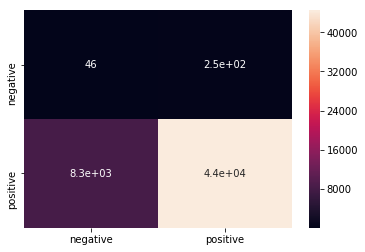

In [58]:
df_cm = pd.DataFrame(con_matrix.T, index = ['negative','positive'],
                  columns = ['negative','positive'])
heatmap(df_cm,annot=True)
plt.plot()

#### Above is the confusion matrix

In [60]:
tn,fp,fn,tp = sklearn.metrics.confusion_matrix(y_test,pred,labels=[-1,1]).ravel()

In [62]:
prec_score = sklearn.metrics.precision_score(y_test,pred,labels=[-1,1],pos_label=1)
print('The precision score of Naive Bayes on 20% test data is ',prec_score*float(100))

The precision score of Naive Bayes on 20% test data is  84.31866861269594


#### Precision Score is 84.31%

In [63]:
print('TPR is ',float(tp/(tp+fn)))
print('FPR is ',float(fp/(tn+fp)))
print('TNR is ',float(tn/(tn+fp)))
print('FNR is ',float(fn/(tp+fn)))

TPR is  0.9944114096660258
FPR is  0.9944704892414954
TNR is  0.005529510758504628
FNR is  0.005588590333974158


In [65]:
recall_score = sklearn.metrics.recall_score(y_test,pred,pos_label=1)
recall_score

0.9944114096660258

#### Recall Score 96.44% which is nothhing but TPR

In [67]:
f1_score = sklearn.metrics.f1_score(y_test,pred,pos_label=1)
f1_score

0.9125765455272794

#### F1 Score is 91.25%

In [68]:
from sklearn import metrics

In [69]:
print('Classification report for Naive Bayes on the selected ssample is\n\n',metrics.classification_report(y_test,pred))

Classification report for Naive Bayes on the selected ssample is

              precision    recall  f1-score   support

         -1       0.16      0.01      0.01      8319
          1       0.84      0.99      0.91     44734

avg / total       0.74      0.84      0.77     53053



#### Summary
- The dataset is large and imbalanced. Because of memory constraint a small sample was taken
- The sampled dataset was sorted according to time
- The sorted dataset was splitted into train and test set
- In **BagOfWord** approach
  1. CountVectors for train data obtained
  2. **BernoulliNB** applied on train vectors
  3. Getting the important features
  4. CountVectors for test data obtained
  5. Applying model on test vectors to get performnce metrices
  6. Done steps 2,3,4,5 with **MultinomilaNB**
  
- Repeating the above 6 steps of BagOfWords approach in **Tfidf** approach